In [1]:
# Python version must be 3.9
#tensorflow version must be 2.12.0
import sys
from math import floor
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import tensorflow as tf
from tensorflow.python.keras import layers, models
import matplotlib.pyplot as plt
from seaborn import heatmap

print(sys.version_info, tf.__version__)


sys.version_info(major=3, minor=11, micro=2, releaselevel='final', serial=0) 2.14.0


Prepare data for Method 1

In [11]:
data = pd.read_csv("creditcard_2023.csv")
creditData = pd.DataFrame(data)
print(creditData.head(5))
columnNames = [f"V{n + 1}" for n in range(28)]
columnNames.append("Amount")
rawInputData = creditData[columnNames].values
rawOutputData = creditData[["Class"]].values
dataSize = creditData[["id"]].values.max()
print(f"The data has {dataSize} rows of data, each containing 29 + 1 cells.")
print("Of those V1...V28 and Amount cells function as input data and Class is the output data")

   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28    Amount  C

Shuffle the data to ensure the testing and training sets contain both positives and negatives

In [12]:
allData = np.concatenate((rawInputData, rawOutputData), axis=1)
np.random.shuffle(allData)

Prepare the data for the MLP

In [13]:
X_train = allData[:floor(dataSize*0.9), :29]
y_train = allData[:floor(dataSize*0.9), 29:].reshape(-1,)
X_test = allData[floor(dataSize*0.9):, :29]
y_test = allData[floor(dataSize*0.9):, 29:].reshape(-1,)

print(f"\nTesting size (x, y): {X_test.shape, y_test.shape}")
print(f"Training size (x, y): {X_train.shape, y_train.shape}")


Testing size (x, y): ((56864, 29), (56864,))
Training size (x, y): ((511766, 29), (511766,))


Initialise the classifier

In [14]:
classifier = MLPClassifier(hidden_layer_sizes=(50, 25, 10, 5,), activation="logistic", early_stopping=True, validation_fraction=0.2)

Train the classifier and predict the test data

In [15]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [16]:
accuracyMLP = accuracy_score(y_test, y_pred)
precisionMLP = precision_score(y_test, y_pred)
conf_matMLP = confusion_matrix(y_test, y_pred)

In [17]:
print(f"Loss: {classifier.loss_}")
print(f"Accuracy: {accuracyMLP}")
print(f"Precision: {precisionMLP}")
print(f"ConfMat:\n {conf_matMLP}")

Loss: 0.15713053811831607
Accuracy: 0.9597636465953855
Precision: 0.977881815165702
ConfMat:
 [[28049   600]
 [ 1688 26527]]


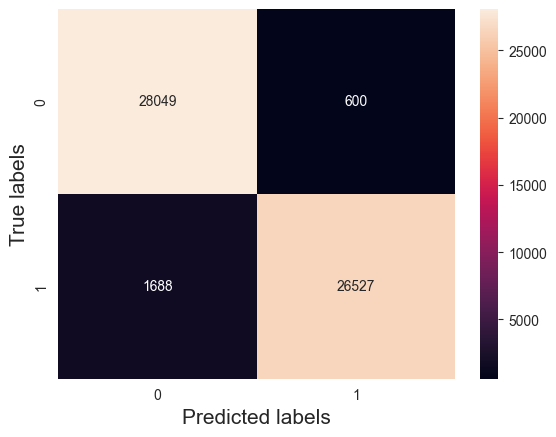

In [18]:
ax = plt.subplot()
heatmap(conf_matMLP,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

Initialise the data for the CNN

In [19]:
# As tf doesn't automatically split validation data then previous training data 80% to train and 20%
# to validation, the test data stays the same
train_size = X_train.shape[0]
print(train_size)
X_val = X_train[floor(train_size*0.8):, :29].reshape(-1, 29, 1)
y_val = y_train[floor(train_size*0.8):].reshape(-1,1)
X_train = X_train[:floor(train_size*0.8), :29].reshape(-1, 29, 1)
y_train = y_train[:floor(train_size*0.8)].reshape(-1,1)
X_test = X_test.reshape(-1, 29, 1)
y_test = y_test.reshape(-1,1)

511766


In [20]:
#Print the sizes 
print(f"\nTesting size (x, y): {X_test.shape, y_test.shape}")
print(f"Validation size (x, y): {X_val.shape, y_val.shape}")
print(f"Training size (x, y): {X_train.shape, y_train.shape}")
tot = X_test.shape[0] + X_val.shape[0] + X_train.shape[0]
print(f"total={tot}")
print(f"{(X_test.shape[0] / tot):0.2f}, {(X_val.shape[0] / tot):0.2f},"
      f"{(X_train.shape[0] / tot):0.2f}")


Testing size (x, y): ((56864, 29, 1), (56864, 1))
Validation size (x, y): ((102354, 29, 1), (102354, 1))
Training size (x, y): ((409412, 29, 1), (409412, 1))
total=568630
0.10, 0.18,0.72


Initialise the CNN model

In [21]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=X_train.shape[1:]))
model.add(layers.Conv1D(64, 6, activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 64)            448       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
None


Train the model

In [22]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy())
history = model.fit(X_train, y_train, batch_size=64, epochs=6, validation_data=(X_val, y_val))

Epoch 1/6


2023-10-11 01:29:44.827775: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6398/6398 [==============================] - 27s 4ms/step - loss: 0.7733 - val_loss: 0.3969
Epoch 2/6
6398/6398 [==============================] - 27s 4ms/step - loss: 0.1253 - val_loss: 0.1230
Epoch 3/6
6398/6398 [==============================] - 27s 4ms/step - loss: 0.0716 - val_loss: 0.0471
Epoch 4/6
6398/6398 [==============================] - 28s 4ms/step - loss: 0.0425 - val_loss: 0.0372
Epoch 5/6
6398/6398 [==============================] - 27s 4ms/step - loss: 0.0289 - val_loss: 0.0343
Epoch 6/6
6398/6398 [==============================] - 27s 4ms/step - loss: 0.0250 - val_loss: 0.0231


In [23]:
y_pred = np.rint(model.predict(X_test).reshape(-1,))
y_test = y_test.reshape(-1,)
print(f"pred: {y_pred.shape}, test: {y_test.shape}")
print(y_pred[:5])

pred: (56864,), test: (56864,)
[0. 1. 0. 0. 1.]


In [24]:
conf_matCNN = confusion_matrix(y_test, y_pred)
accuracyCNN = accuracy_score(y_test, y_pred)
precisionCNN = precision_score(y_test, y_pred)

In [25]:
print(f"Loss: {history.history['loss'][-1]}")
print(f"Accuracy: {accuracyCNN}")
print(f"Precision: {precisionCNN}")
print(f"ConfMat:\n {conf_matCNN}")

Loss: 0.024966174736618996
Accuracy: 0.9939328925154756
Precision: 0.9930648927889039
ConfMat:
 [[28453   196]
 [  149 28066]]


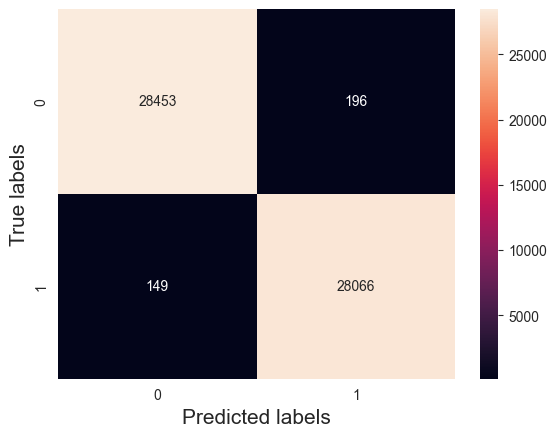

In [26]:
ax = plt.subplot()
heatmap(conf_matCNN,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()